In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Measurement

In [2]:
Hz = 100.0 # Frequency of Vision System
dt = 1.0/Hz
T = 1.0 # s measuremnt time
m = int(T/dt) # number of measurements

px= 0.0 # x Position Start
py= 0.0 # y Position Start
pz= 1.0 # z Position Start

vx = 10.0 # m/s Velocity at the beginning
vy = 0.0 # m/s Velocity
vz = 0.0 # m/s Velocity

c = 0.1 # Drag Resistance Coefficient
d = 0.9 # Damping

Xr=[]
Yr=[]
Zr=[]
for i in range(int(m)):
    accx = -c*vx**2  # Drag Resistance
    
    vx += accx*dt
    px += vx*dt

    accz = -9.806 + c*vz**2 # Gravitation + Drag
    vz += accz*dt
    pz += vz*dt
    
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
    if vx<0.1:
        accx=0.0
        accz=0.0
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)

## Add noise

In [3]:
sp= 0.1 # Sigma for position noise

Xm = Xr + sp * (np.random.randn(m))

Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

(-1.6806805096386426, 2.8684002439525282)

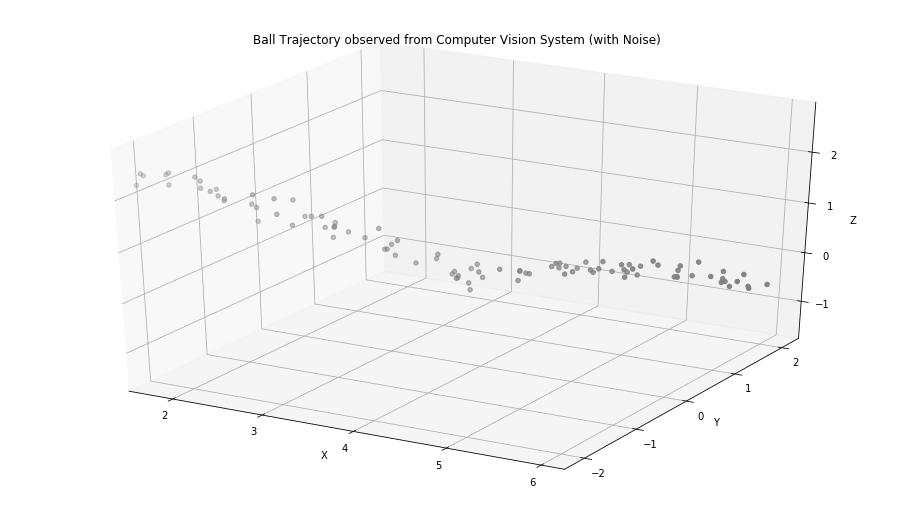

In [4]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm, Ym, Zm, c='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Ball Trajectory observed from Computer Vision System (with Noise)')

#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)

## cv2 kalman

In [5]:
import cv2

In [6]:
v = dt
a = 0.5 * (dt**2)

In [94]:
kalman = cv2.KalmanFilter(9, 3, 0)

kalman.measurementMatrix = np.array([
        [1, 0, 0, v, 0, 0, a, 0, 0],
        [0, 1, 0, 0, v, 0, 0, a, 0],
        [0, 0, 1, 0, 0, v, 0, 0, a]
    ],np.float32)

kalman.transitionMatrix = np.array([
        [1, 0, 0, v, 0, 0, a, 0, 0],
        [0, 1, 0, 0, v, 0, 0, a, 0],
        [0, 0, 1, 0, 0, v, 0, 0, a],
        [0, 0, 0, 1, 0, 0, v, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, v, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, v],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]
    ],np.float32)

kalman.processNoiseCov = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]
    ],np.float32) * 0.007

kalman.measurementNoiseCov = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0 ,1]
    ],np.float32) * sp

# kalman.statePost = np.array([[Xm[0]],[Ym[0]],[Zm[0]], [0], [0], [0], [0], [0], [0]])
kalman.statePre = np.array([
                                [np.float32(Xm[0])], [np.float32(Ym[0])], [np.float32(Zm[0])]
                               , [np.float32(0.)], [np.float32(0.)], [np.float32(0.)]
                               , [np.float32(0.)], [np.float32(0.)], [np.float32(0.)]
                           ])
# kalman.statePre = np.array([
#                                 [0.],[0.],[0.]
#                                , [0.], [0.], [0.]
#                                , [0.], [0.], [0.]
#                            ])
print(type(kalman.statePre[0][0]))

<class 'numpy.float32'>


In [95]:
mp = np.array((3, 1), np.float32) # measurement
tp = np.zeros((3, 1), np.float32)

In [96]:
xt = []
yt = [] 
zt = []
for i in range(m):
    mp = np.array([
        [np.float32(Xm[i])],
        [np.float32(Ym[i])],
        [np.float32(Zm[i])]
    ])
    kalman.correct(mp)
    tp = kalman.predict()
    xt.append(float(tp[0]))
    yt.append(float(tp[1]))
    zt.append(float(tp[2]))

(-1.6806805096386426, 2.8684002439525282)

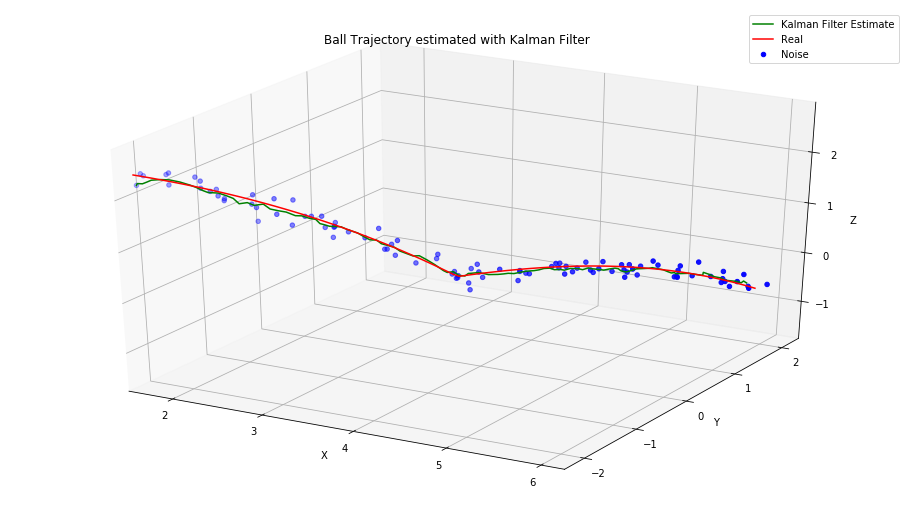

In [97]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate', c='green')
ax.plot(Xr, Yr, Zr, c='red', label='Real')
ax.scatter(Xm, Ym, Zm, c='blue', label='Noise')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Ball Trajectory estimated with Kalman Filter')

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)